In [1]:
# Jonathan_Hamburg_DATS6103
# Project 2 -- Vegetarian and Vegan Restaurants, collected by Datafinity and downloaded from Kaggle.com

# Set up ---------- 
%matplotlib inline 
# Import modules
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import uszipcode
from ast import literal_eval
from mpl_toolkits.basemap import Basemap

from IPython.core.display import display, HTML
from IPython.core.debugger import set_trace

In [2]:
# update Jupyter Notebook display
display(HTML("<style>.container {width:85% !important;} </style>"))

In [3]:
# Read in raw data
filename = 'vegetarian_restaurants_US_datafiniti.csv'
raw = pd.read_csv('data/' + filename)

In [4]:
raw.columns

Index(['address', 'categories', 'city', 'claimed', 'country', 'cuisines',
       'dateOpened', 'dateUpdated', 'descriptions', 'facebookPageURL',
       'features', 'hours', 'images', 'isClosed', 'key', 'lat', 'languages',
       'long', 'menus', 'menuURL', 'name', 'paymentTypes', 'phones',
       'postalCode', 'priceRange', 'province', 'sic', 'twitter', 'websites'],
      dtype='object')

# Clean Dataset

## Drop Unnecessary Columns

In [5]:
# Drop unused columns:
raw = raw.drop(['categories', 'country', 'claimed', 'address', 'sic',
                'dateUpdated', 'images', 'key', 'descriptions', 'hours',
                'languages', 'menus', 'menuURL', 'phones'], axis = 1)
raw.head(3)

,city,cuisines,dateOpened,facebookPageURL,features,isClosed,lat,long,name,paymentTypes,postalCode,priceRange,province,twitter,websites
0,Clearwater,NaN,NaN,NaN,NaN,NaN,27.971165,-82.696938,Village Inn Restaurant and Bakery,NaN,33759,NaN,FL,NaN,NaN
1,Louisville,"Vegetarian, Delicatessen",NaN,NaN,"[{""key"":""Value Rating"",""value"":""3.5 of 5 stars...",NaN,38.257020,-85.760013,Atlantic No. 5,Yes,40202,USD 25.00-40.00,KY,NaN,atlanticno5.com
2,Puyallup,NaN,NaN,NaN,NaN,NaN,47.154828,-122.303992,Famous Dave's,NaN,98373,USD 10.00 - USD 15.00,WA,NaN,http://famousdaves.com


## Location

### Functions to Clean Area Variables

In [6]:
# Clean up miscoded State variable and rename as State
def cleanStateVar(dat):
    dat = dat.replace({'province': {'AU-WA':'WA'}})
    dat = dat.rename(columns = {'province':'state'})
    return(dat)

# Add location based on zip code
def addLocationInfoByState(dat):
    # clean up zipcode column
    dat['zip'] = raw.postalCode.str.extract('(\d+)', expand=True)
    dat.drop('postalCode', axis = 1, inplace = True)
    
    # Set up object to look through zipcodes
    search = uszipcode.ZipcodeSearchEngine()
    
    # Loop through zip codes to get area information
    uniqZips = dat['zip'][dat.zip.notnull()].unique()
    zipCityState = pd.DataFrame(columns=['Zipcode', 'City', 'State', 'Population', 'Wealthy'])
    for i in range(len(uniqZips)):
        tmp = search.by_zipcode(int(uniqZips[i]))
        zipCityState.loc[i, :] = dict(tmp)
    
    # delete zipcodes not included in package
    zipCityState = zipCityState[zipCityState['Zipcode'].notnull()]
    
    merged = dat.merge(zipCityState, how='left', left_on='zip', right_on='Zipcode', sort = False)
    merged.drop('Zipcode', axis = 1, inplace = True)

    # clean city and state
    res = merged.assign(city = np.where(merged.city.isnull(), merged.City, merged.city),
                        state = np.where(merged.state.isnull(), merged.State, merged.state))
    
    # rename and drop unnecessary columns
    res.drop(['City', 'State'], axis = 1, inplace = True)
    res.rename(columns = {'Population':'pop', 'Wealthy': 'wages'})
    return(res)

### Clean Area Variables

In [7]:
cleanedLocation = addLocationInfoByState(cleanStateVar(raw))

## Price

### Functions to clean up Price

In [8]:
#...............................................
# Main function to create new price variables
#...............................................

# Combine coverted $ and actual price amounts into one price unit.
# Will also create discretized price variable based on dollar sign
def cleanPrice(dat, priceLowRange, priceHighRange):
    if not 'priceRange' in dat.columns:
        raise ValueError('Data argument did not include variable priceRange')
    
    price = dat['priceRange']
    
    # Convert $ to numeric amounts
    tmpDict = {'lowPriceConvert': convertLowRangeDollarSign(price, priceLowRange),
               'highPriceConvert': convertHighRangeDollarSign(price, priceHighRange)}
    convertPrice = pd.DataFrame(tmpDict)
    
    # Get already reported numeric amounts
    priceDat = extractPrice(price)
    
    # Combine two together
    finalPrice = pd.concat([priceDat, convertPrice], axis = 1)
    finalPrice = finalPrice.assign(finalLow = np.where(finalPrice.lowPriceConvert.notnull(), 
                                                   finalPrice.lowPriceConvert,
                                                   finalPrice.lowPrice),
                                   finalHigh = np.where(finalPrice.highPriceConvert.notnull(), 
                                                   finalPrice.highPriceConvert,
                                                   finalPrice.highPrice))
    finalPrice = finalPrice[['finalLow', 'finalHigh']]
    finalPrice = finalPrice.rename(columns = {'finalLow':'lowPrice', 'finalHigh': 'highPrice'})
    res = pd.concat([dat, finalPrice], axis = 1)
    res.drop('priceRange', axis = 1, inplace = True)
    return(res)    

#...............................................
# Functions to convert $ to numerics 
#...............................................

def convertLowRangeDollarSign(vect, lowRangeVect):
    res = np.where(vect == '$', lowRangeVect[0],
           np.where(vect == '$$', lowRangeVect[1],
            np.where(vect == '$$$', lowRangeVect[2],
             np.where(vect == '$$$$', lowRangeVect[3], np.NaN))))
    return(res)

def convertHighRangeDollarSign(vect, priceHighRange):
    res = np.where(vect == '$', priceHighRange[0],
           np.where(vect == '$$', priceHighRange[1],
            np.where(vect == '$$$', priceHighRange[2],
             np.where(vect == '$$$$', priceHighRange[3], np.NaN))))
    return(res)

def descritzePrice(vect, priceHighRange):
    res = np.where(vect.isnull(), np.nan,
            np.where(vect < priceHighRange[0], '$',
             np.where(vect < priceHighRange[1], '$$',
              np.where(vect < priceHighRange[2], '$$$',
                       '$$$$'))))
    return(res)

#...............................................
# Functions to extract numeric price amount 
#...............................................
# Convert price object from range string to multiple variables, low and high
def extractPrice(vect):
    # Update commas to decimals and mistype Aussie Dollar to American Dollar
    price = vect.replace({',': '.', 'AUD': 'USD'}, regex = True)

    # Extract low and high price
    priceVars = price.str.extract(pat='(?P<lowPrice>\d+.?\d+?)\D+(?P<highPrice>\d+.?\d+?)', expand = True)

    # Convert price to numerics
    return(priceVars.apply(pd.to_numeric))


### Code to clean up price

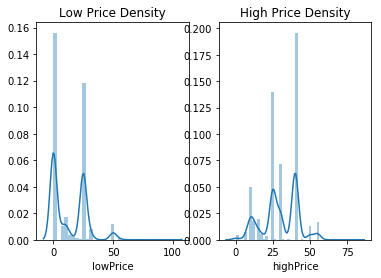

In [9]:
#.....................................................
# Fill in price variable where only dollar signs are
# used ($, $$, $$$, $$$$). Determine breaks using 
# density plots for low and high price

priceDat = extractPrice(cleanedLocation.priceRange)

# Will keep to less than 100 since few outliers skew data
plt.subplot(1, 2, 1)
lowPrice = priceDat.lowPrice[priceDat.lowPrice < 100].dropna()
sns.distplot(lowPrice)
plt.title('Low Price Density')

plt.subplot(1, 2, 2)
highPrice = priceDat.highPrice[priceDat.highPrice < 100].dropna()
sns.distplot(highPrice)
plt.title('High Price Density')

# Clean up workspace
del priceDat, lowPrice, highPrice

In [10]:
# Looks like the range are:
priceLowRange = [0, 15, 25, 50]
priceHighRange = [10, 25, 40, 60]


In [11]:
# Clean up price column
updatedPrice = cleanPrice(cleanedLocation, priceLowRange, priceHighRange)
updatedPrice['avgPrice'] = updatedPrice[['lowPrice', 'highPrice']].mean(axis = 1)
updatedPrice['discretizedPrice'] = descritzePrice(updatedPrice.avgPrice, priceHighRange)                                          

## Dates

In [12]:
# Function to turn date column into a date type
def fixDate(vect):
    tmp = vect.str.extract('(.+)T', expand = False)
    res = pd.to_datetime(tmp, format='%Y-%m-%d', errors = 'coerce')
    return(res)

cleanedDates = updatedPrice.assign(openDat = fixDate(updatedPrice.dateOpened))
cleanedDates.drop('dateOpened', axis = 1, inplace=True)
cleanedDates = cleanedDates.assign(openYear = cleanedDates.openDat.map(lambda x: x.year),
                                   openMonth = cleanedDates.openDat.map(lambda x: x.month))

## Features

This column contains information such as reviews and ratings (Overall, Value and Service) among other features.  I separate this one column into several columns, only opting to keep a select few variables that I use in the analysis later on.

### Feature cleaning functions

In [13]:
# Turn string of dictionaries representing JSON into 
# an actual dictionary. Current string reads:
# '{"key": "blah", "value": "blah2"}, {"key": "blah3", "value": "blah4"}'
#   and will turn into:
#  {"blah":"blah2", "blah3": "blah4"}
def cleanFeatureFromJSONToDict(string):
    if not isinstance(string, str):
        return(None)
    # Need to remove brackets and replace slashes for literal eval to work
    stringNoBrackets = literal_eval(string.strip('[]').replace('\\"', "'"))
    resDict = {}
    
    # See if feature is only one dict or list/tuple of dicts
    if isinstance(stringNoBrackets, dict):
        resDict[stringNoBrackets['key']] = stringNoBrackets['value']
    else:
        for i in range(len(stringNoBrackets)):
            try:
                isDict = isinstance(stringNoBrackets[i], dict)
                if isDict:
                    # In case Key is a tuple of two items, will only use the first
                    if not isinstance(stringNoBrackets[i]['key'], str):
                        resDict[stringNoBrackets[i]['key'][0]] = stringNoBrackets[i]['value']    
                    else:
                        resDict[stringNoBrackets[i]['key']] = stringNoBrackets[i]['value']
            except:
                set_trace()
    return(resDict)


# These functions will create a series based on several columns that
# have different names but mean the same thing

# Function to return a numeric. If an observation happens
# have 2 values, it will return an average
def createNumericFeatureSeries(key, val, dat):
    convNumFunc = lambda x: pd.to_numeric(x.str.extract('(\d+)', expand = False))
    tmp = dat[val].apply(convNumFunc).mean(axis = 1)
    tmp.rename(key, inplace = True)
    return(tmp)

def createStrFeatureSeries(key, val, dat):
    if isinstance(val, list):
        tmp = dat[val].apply(lambda x: ''.join(x.dropna()),axis=1)
        tmp.rename(key, inplace = True)
    else:
        tmp = dat[val]
        tmp.rename(key, inplace = True)
    return(tmp)

In [14]:
# wrapper function for cleaning features
def cleanFeatures(dat):
    # Create a DataFrame of all features only
    features = pd.DataFrame(dat.features.map(cleanFeatureFromJSONToDict).apply(pd.Series))

    # List of all features created: (UNCOMMENT IF WANT TO SEE)
    # features.columns.tolist()

    # These are features decided to keep
    numKeepFeatureDict = {'overallRating': ['Overall Rating', 'TripAdvisor Overall Rating', 
                               'Trip Advisor Traveler Rating', 'Booking Review Score', 'Average Rating'],
                          'serviceRating': ['Booking Staff Score', 'Service Rating', 'Service Score', 'Service Summary Rating'],
                          'valueRating': ['Booking Value for money Score', 'Value Rating', 'Value'],
                          'numReviews': ['Booking Total Number of Reviews', 'Number of Trip Advisor Reviews']}
    strKeepFeatureDict = {'reservations': ['Takes Reservations', 'Reservations'],
                          'outdoor': ['Outdoor Seating']}        

    keepFeatures = pd.DataFrame()
    for key, val in numKeepFeatureDict.items():
        if key in keepFeatures.columns:
            keepFeatures.drop(key, inplace=True)
        keepFeatures = pd.concat([keepFeatures, createNumericFeatureSeries(key, val, features)],
                                 axis = 1)

    for key, val in strKeepFeatureDict.items():
        if key in keepFeatures.columns:
            keepFeatures.drop(key, inplace=True)
        keepFeatures = pd.concat([keepFeatures, createStrFeatureSeries(key, val, features)],
                                 axis = 1)

    res = pd.concat([dat.drop('features', axis = 1), keepFeatures], axis = 1)
    return(res)

In [15]:
cleanedFeatures = cleanFeatures(cleanedDates)

# One fix for reservations:
cleanedFeatures['reservations'] = np.where((cleanedFeatures['reservations'].notnull()) & (cleanedFeatures['reservations'] != 'No'), 'Yes', cleanedFeatures['reservations'])

## Web Presence and Social Media

In [16]:
socialMediaFunc = lambda x: np.where(x.facebookPageURL.notnull() |
                                       x.twitter.notnull(), True, False)

cleanedWeb = cleanedFeatures.assign(socialMedia = socialMediaFunc(cleanedFeatures),
                                    web = cleanedFeatures.websites.notnull())
cleanedWeb.drop(['facebookPageURL', 'twitter', 'websites'], axis = 1, inplace=True)

## Miscellaneous

### Chain Restaurants

From initial investigations into the dataset, some of the restaurant names seem to be chain. Will identify chain restaurants by those that have the same name at least 5 different times. I will assume that the same can be used at least 4 times by different establishments in different areas but after 5 times, will assume the restaurant is a chain.

In [17]:
numInst = cleanedWeb['name'].value_counts()
isChain = numInst[numInst > 4]
miscDat = cleanedWeb.assign(chain = np.where(cleanedWeb.name.isin(isChain.index), 'chain', 'no chain'))

### Cuisines

Create columns for popular styles of foods. Also will create a column to see if meat is served at the restaurant.

In [18]:
# Columns for popular foods
cuisineList = ['american', 'asian', 'french', 'german', 'greek', 'indian', 'italian', 'mexican']
for food in cuisineList:
    miscDat[food + 'Food'] = (miscDat.cuisines.str.contains(food, case=False)) & (miscDat.cuisines.notnull())
    
# Fixes for certain foods that are known under differnt names
miscDat['italianFood'] = (miscDat.italianFood) | (miscDat.cuisines.str.contains('pizza', case=False)) & (miscDat.cuisines.notnull())
miscDat['mexicanFood'] = (miscDat.mexicanFood) | (miscDat.cuisines.str.contains('taco', case=False)) & (miscDat.cuisines.notnull())
    
# Column if meat is served
meatList = ['', 'meat', 'beef', 'pork', 'hamburger', 'hot dog']
miscDat['servesMeat'] = (miscDat.cuisines.str.contains('|(?:(?<!no)|(?<!not)) ?'.join(meatList)[1:], case=False)) & (miscDat.cuisines.notnull())
miscDat.drop('cuisines', axis = 1, inplace = True)

### Payment Types

In [19]:
cards = ['', 'visa', 'mastercard', 'debit', 'discover', 'amex', 
         'american express', 'diners club', 'all major credit cards']

miscDat['cards'] = (miscDat.paymentTypes.str.contains('|(?:(?<!no)|(?<!not)) ?'.join(cards)[1:], case=False, regex=True)) & (miscDat.paymentTypes.notnull())
miscDat['check'] = (miscDat.paymentTypes.str.contains('(?:(?<!no)|(?<!not)) ?check', case=False, regex = True)) & (miscDat.paymentTypes.notnull())
miscDat['cash'] = (miscDat.paymentTypes.str.contains('(?:(?<!no)|(?<!not)) ?cash', case=False, regex = True)) & (miscDat.paymentTypes.notnull())
miscDat.drop('paymentTypes', axis = 1, inplace = True)

miscDat['paymentType'] = np.where((miscDat.cards) & (miscDat.check) & (miscDat.cash), 'all accepted',
                          np.where((miscDat.cards) & (~miscDat.check) & (~miscDat.cash), 'cards only',
                           np.where((~miscDat.cards) & (~miscDat.check) & (miscDat.cash), 'cash only',                         
                                     'other')))

In [20]:
# Clean isClosed variable

miscDat['isClosed'] = np.where(miscDat.isClosed.str.contains('false', case = False), False,
                       np.where(miscDat.isClosed.str.contains('true', case = False), True,
                                miscDat.isClosed))


## End of Cleaning Section

Save the last dataset into a new object that will be used for anlaysis. Will also clean up my workspace to save memory. Lastly, will output the dataset to a CSV so that in the future, can read that in without having to re-run all of the code above.

In [21]:
cleanedDat = miscDat.copy()
del miscDat, cards, meatList, cuisineList, numInst, isChain, cleanedWeb, cleanedFeatures, cleanedDates, updatedPrice, cleanedLocation, raw

In [22]:
cleanedDat.to_csv('data/cleanedDat.csv', index = False)

In [23]:
cleanedDat = pd.read_csv('data/cleanedDat.csv')

# Exploratory Analysis

## Price and Features

In this section, I will look at restaurants by price and see if there are any differences between those institutions. For the differences I will look at the features of the dataset.

In [24]:
# Function to plot grouped horizontal bar charts of price and other features specified
def calcStatByPrice(dat, groupVar, valueVar, stat, plotKind = 'barh', 
                    xlabel = None, ylabel = None,
                    title = None, ax = None, legend = True):

    if not callable(stat):
        raise TypeError('Stat object must be a function')
        
    if ax is None:
        raise ValueError('ax arguement must contain a valid graph location')
        
    tmpDat = dat[['discretizedPrice', groupVar, valueVar]].dropna(axis = 0, how = 'any')
    tmpDat = dat.assign(discretizedPrice = dat.discretizedPrice.str.replace('$', '\$'))
    tmpDat = tmpDat.pivot_table(index = 'discretizedPrice', columns = groupVar, values = valueVar, aggfunc=stat)
    pltRes = tmpDat.plot(kind = plotKind, ax = ax, legend = False, )

    pltRes.set_xlabel("")
    pltRes.set_ylabel("")
    
    if not xlabel is None:
        pltRes.set_xlabel(xlabel)
    
    if not ylabel is None:
        pltRes.set_ylabel(ylabel)

    if not title is None:
        pltRes.set_title(title)
    
    if legend:
        pltRes.legend(loc=9, bbox_to_anchor=(0.5, -0.05), ncol=2, title = groupVar)

#### Price Groupings by Ratings (overall, value and service) and Amenities (Web Presence, Social Media Presence, Outdoor Seating)

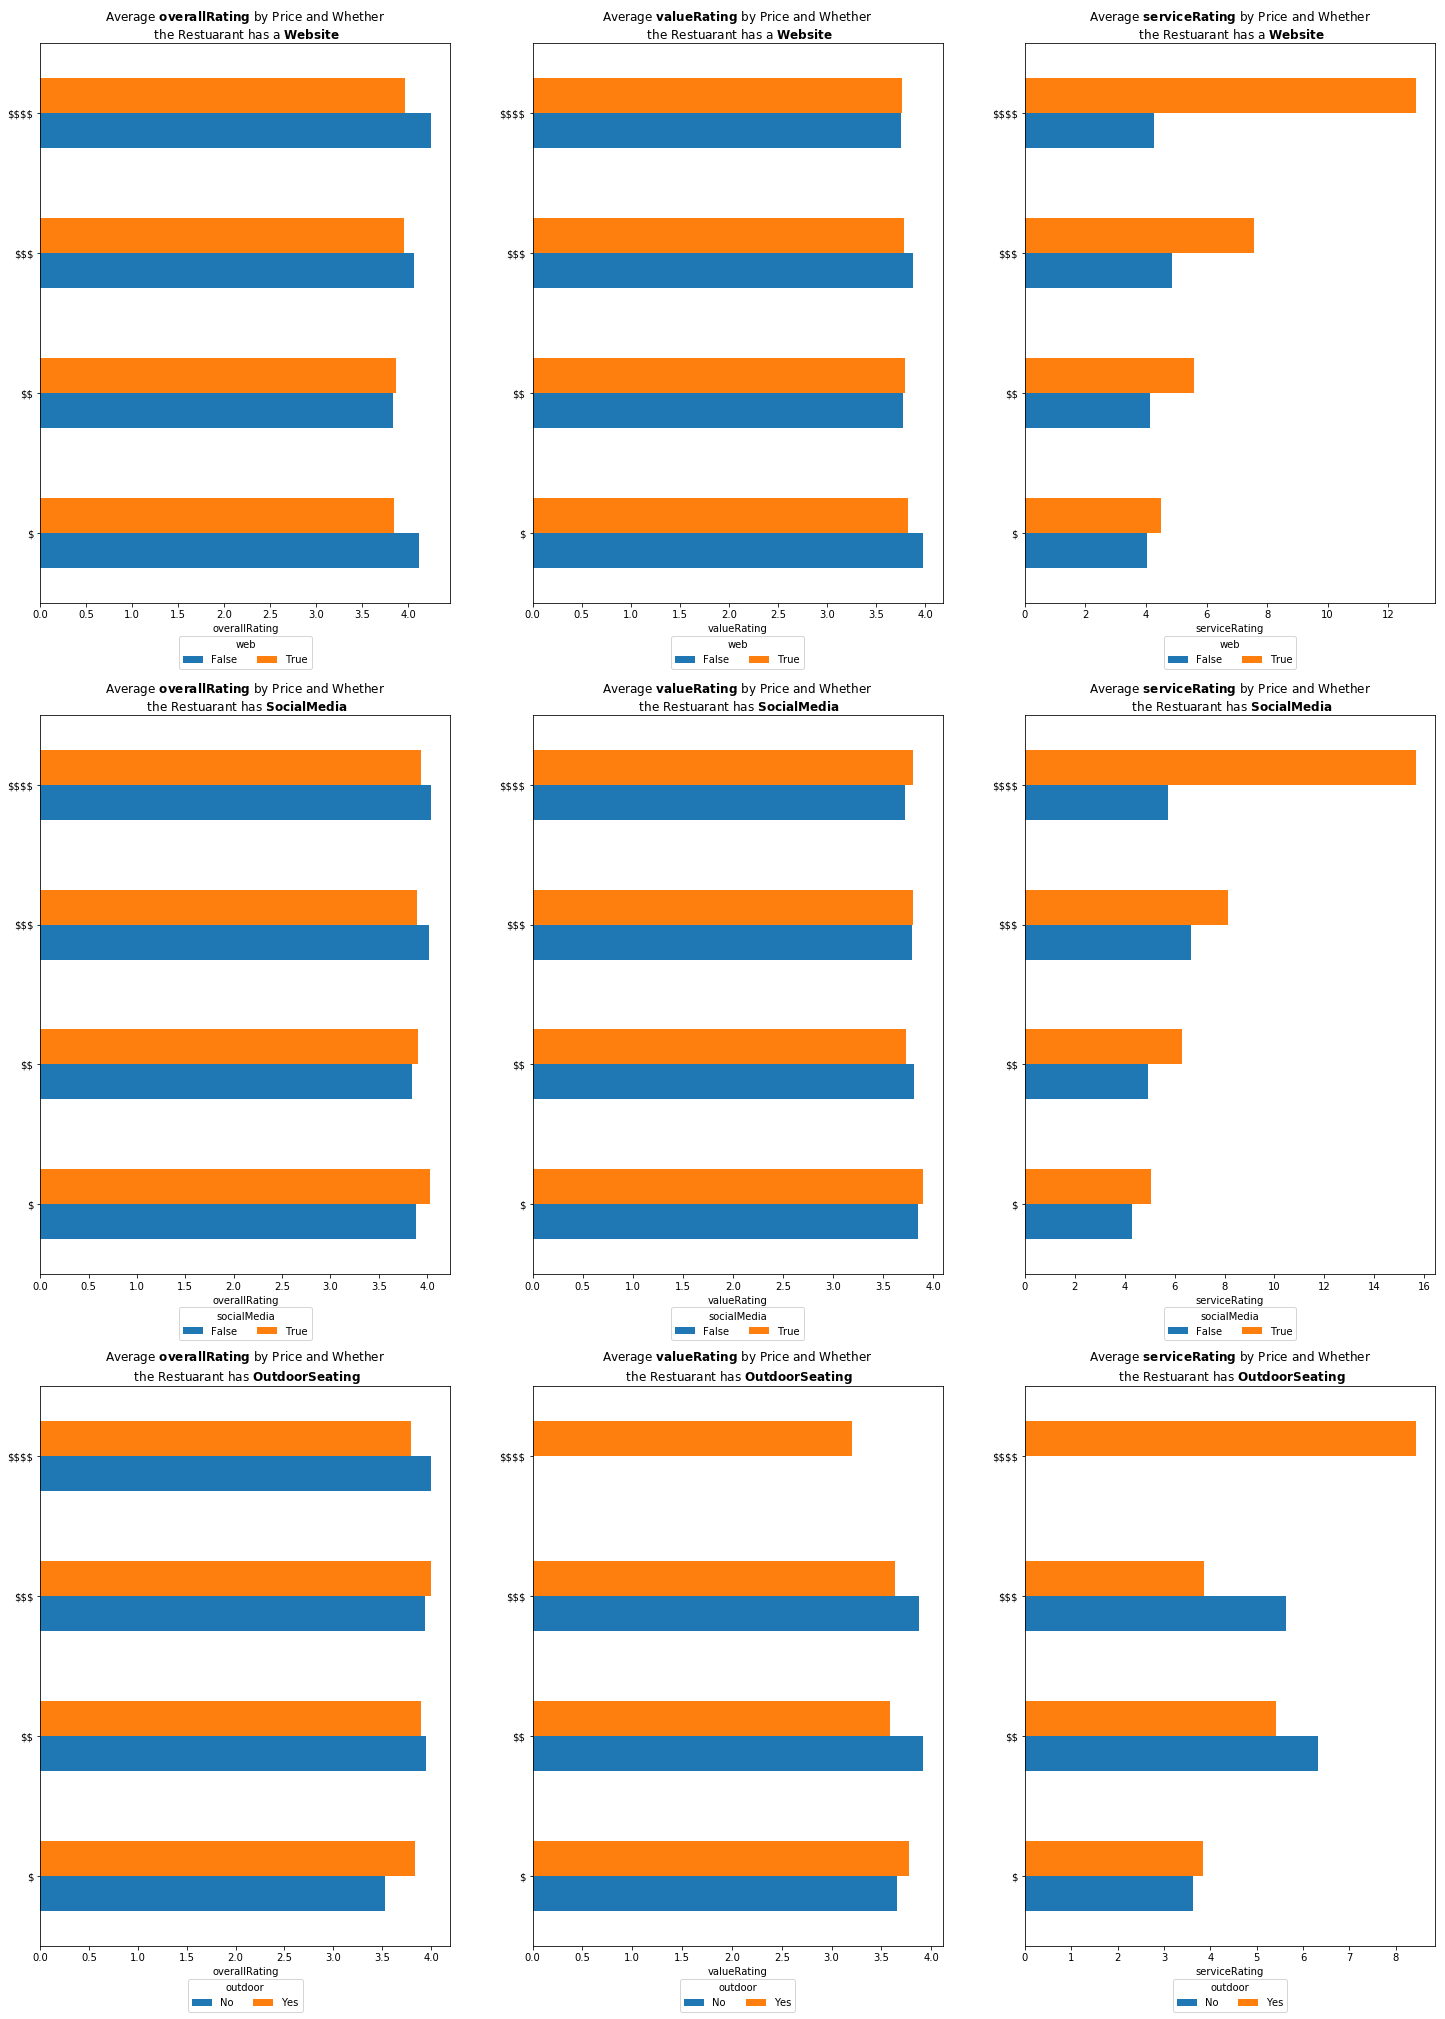

In [25]:
fig, axes = plt.subplots(figsize=(25, 35), nrows = 3, ncols = 3)
ratingTypes = ['overallRating', 'valueRating', 'serviceRating']
for ratI in range(len(ratingTypes)):
    calcStatByPrice(cleanedDat, 'web', ratingTypes[ratI], lambda x: round(np.mean(x), 2),
                    xlabel = ratingTypes[ratI], 
                    title = 'Average ' +  r"$\bf{" + str(ratingTypes[ratI]) + "}$" + ' by Price and Whether\n the Restuarant has a ' + r"$\bf{" + str('Website') + "}$",
                    ax = axes[0, ratI])

    calcStatByPrice(cleanedDat, 'socialMedia', ratingTypes[ratI], lambda x: round(np.mean(x), 2),
                    xlabel = ratingTypes[ratI], 
                    title = 'Average ' +  r"$\bf{" + str(ratingTypes[ratI]) + "}$" + ' by Price and Whether\n the Restuarant has ' + r"$\bf{" + str('Social Media') + "}$",
                    ax = axes[1, ratI])

    calcStatByPrice(cleanedDat, 'outdoor', ratingTypes[ratI], lambda x: round(np.mean(x), 2),
                    xlabel = ratingTypes[ratI], 
                    title = 'Average ' +  r"$\bf{" + str(ratingTypes[ratI]) + "}$" + ' by Price and Whether\n the Restuarant has ' + r"$\bf{" + str('Outdoor Seating') + "}$",
                    ax = axes[2, ratI])

#### Price Groupings by Misc Attributes

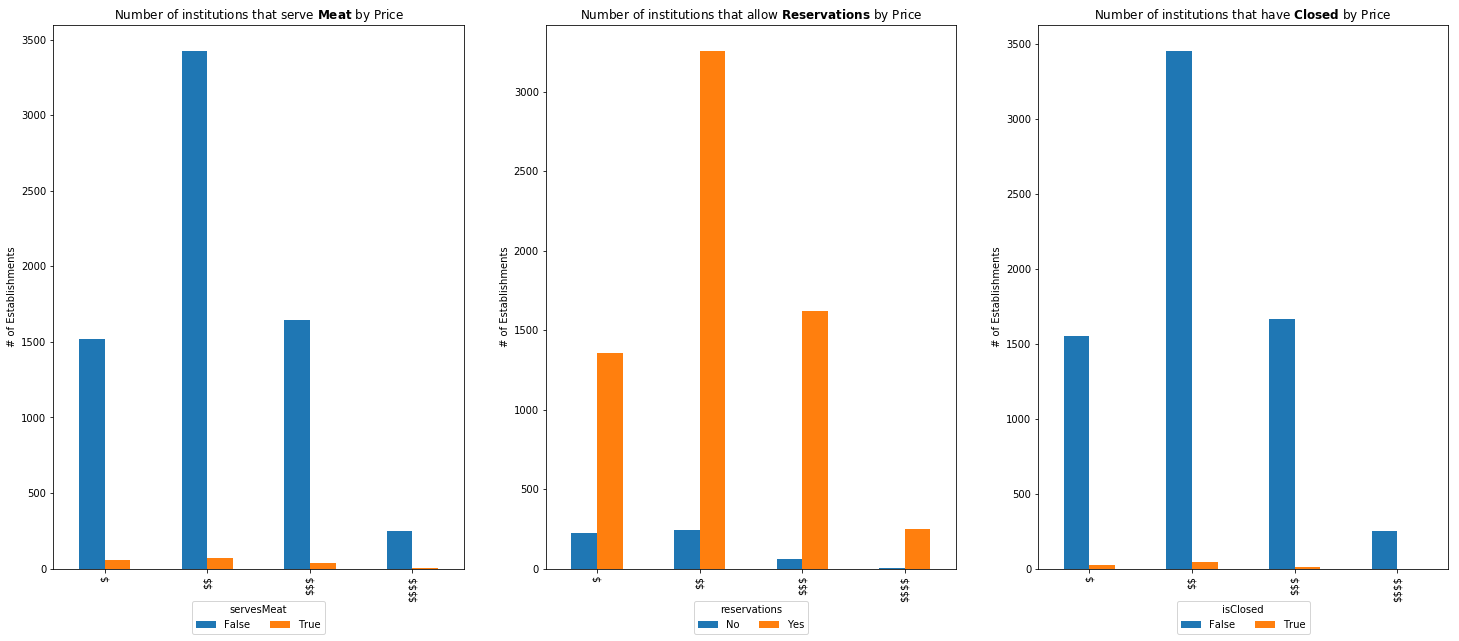

In [26]:
fig, axes = plt.subplots(figsize=(25, 10), nrows = 1, ncols = 3)

calcStatByPrice(cleanedDat, 'servesMeat', 'name', lambda x: x.count(),
                ax = axes[0],
                title = 'Number of institutions that serve ' +  r"$\bf{" + str('Meat') + "}$" + ' by Price',
                ylabel = '# of Establishments', plotKind = 'bar')

calcStatByPrice(cleanedDat, 'reservations', 'name', lambda x: x.count(),
                ax = axes[1],
                title = 'Number of institutions that allow ' +  r"$\bf{" + str('Reservations') + "}$" + ' by Price',
                ylabel = '# of Establishments', plotKind = 'bar')

calcStatByPrice(cleanedDat, 'isClosed', 'name', lambda x: x.count(),
                ax = axes[2],
                title = 'Number of institutions that have ' +  r"$\bf{" + str('Closed') + "}$" + ' by Price',
                ylabel = '# of Establishments', plotKind = 'bar')

## Where are the restaurants located?

In this section, I will plot the resturant locations on map to get a sense of where they 
are located. I will also look at maps based on different attributes such as wealth, payment type and chain to see the distribution of the restaurants for those attributes across the U.S.

In [27]:
def plot_map(lons, lats, size = None, color = None, projection='mill', llcrnrlat=None, title = "",
             urcrnrlat=None, llcrnrlon=None, urcrnrlon=None, resolution='i', min_marker_size=10):
    
    plt.figure(figsize=(20,20))
    if not size is None:
        bins = size.quantile([.2, .4, .6, .8])
        marker_sizes = np.digitize(size, bins) * 6 + min_marker_size
    else:
        marker_sizes = np.repeat(min_marker_size, len(lons))  
    
    # Set arguments if not defined by the user
    if llcrnrlat is None:
        llcrnrlat = lats.min() - 5
    if urcrnrlat is None:
        urcrnrlat = lats.max() + 5
    if llcrnrlon is None:
        llcrnrlon = lons.min() - 5
    if urcrnrlon is None:
        urcrnrlon = lons.max() + 5
        
    # Draw map
    m = Basemap(projection=projection, llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat, llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, resolution=resolution)
    m.drawcoastlines()
    m.drawmapboundary()

    # Convert lat and long to points on map
    x, y = m(lons.tolist(), lats.tolist())
    
    # Looping objects
    colorList = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C8']
    markerList = ['o', '^', 'p', '*', 'v', 'D', 'h', '8']
    
    # Loop through colors and plot each color separately for legend
    if color is None:
        m.scatter(x, y, s = marker_sizes, marker = 'o')
    else:
        cols = color.unique()
        numColorUniqs = len(color.unique())
        
        for colNum in range(numColorUniqs):
            rows = color == cols[colNum]
            xplt = [i for i,j in zip(x,rows) if j]
            yplt = [i for i,j in zip(y,rows) if j]
            splt = [i for i,j in zip(marker_sizes,rows) if j]

            m.scatter(xplt, yplt, s = splt, marker = markerList[colNum], c = colorList[colNum], label = cols[colNum])
        
        # Create legend for color
        plt.legend(scatterpoints=1, labelspacing=1, loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2, markerscale=5)

    plt.title(title);
    
    return m

In order to plot, I need to remove missing and bad data (aka lat, long not in U.S). The east coast of Maine is at longitude of -67 and the base of Hawaii is at latitude of 18.

C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1710: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


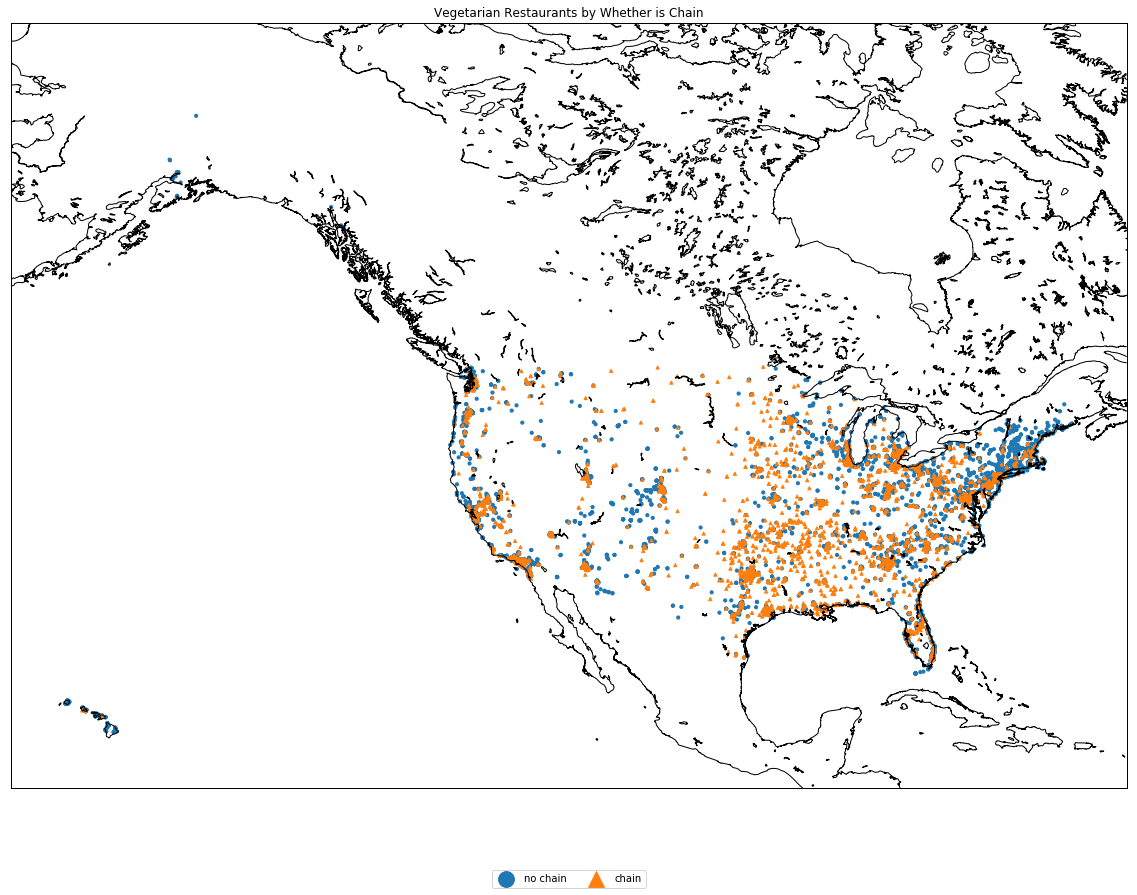

In [28]:
plottingDat = cleanedDat[(cleanedDat.long < -67) & (cleanedDat.lat > 18)]

# Plot based all restaurants

plot_map(plottingDat['long'], plottingDat['lat'], color = plottingDat.chain, 
         title = 'Vegetarian Restaurants by Whether is Chain')

Moving forward, I will also remove Hawaii and Alaska to be able to see the map better.

### Plot of restaurants by Chain and Log(Wealthy)

C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1710: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


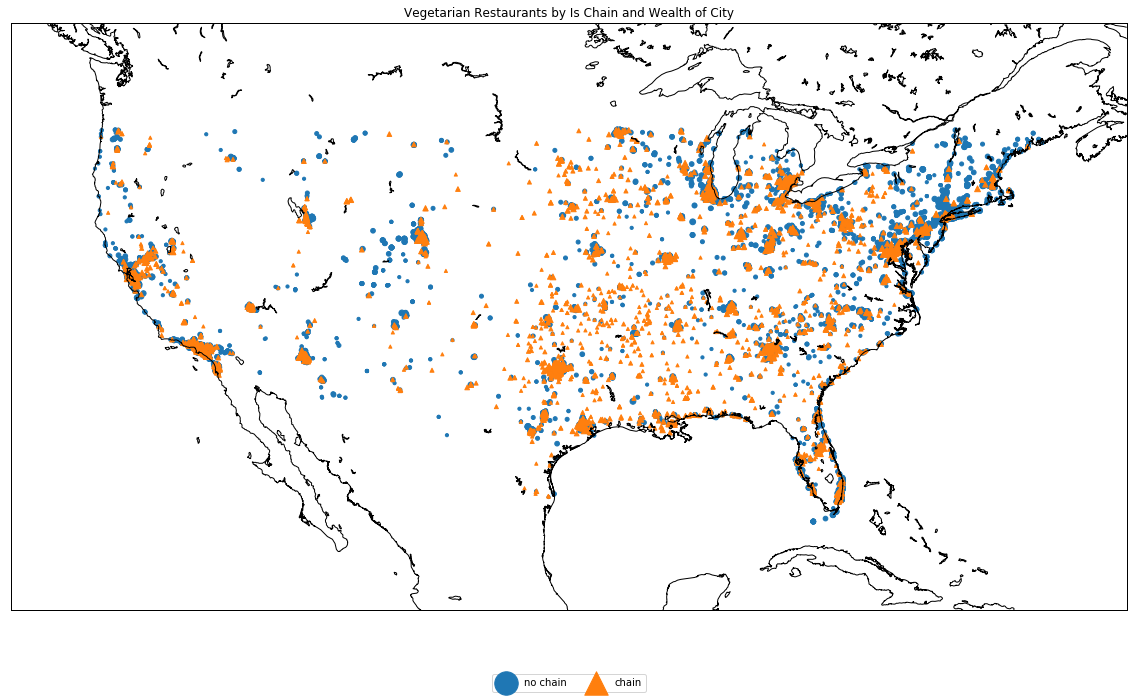

In [29]:
plottingDat = cleanedDat[(cleanedDat.long < -67) & (cleanedDat.long > -125) & 
                          (cleanedDat.lat > 24) & (cleanedDat.lat < 45) &
                          (cleanedDat.Wealthy.notnull()) & (cleanedDat.Wealthy != np.inf)]

# Plot based all restaurants
plt.figure(figsize=(20,20))

# Issue with log function on series, so this is a hack
size = pd.Series(np.log(plottingDat.Wealthy.tolist()))
plot_map(plottingDat['long'], plottingDat['lat'], size, color = plottingDat.chain,
         title = 'Vegetarian Restaurants by Is Chain and Wealth of City')
del size

### Plot of restaurants by Payment Types

C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1710: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Hamburg\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


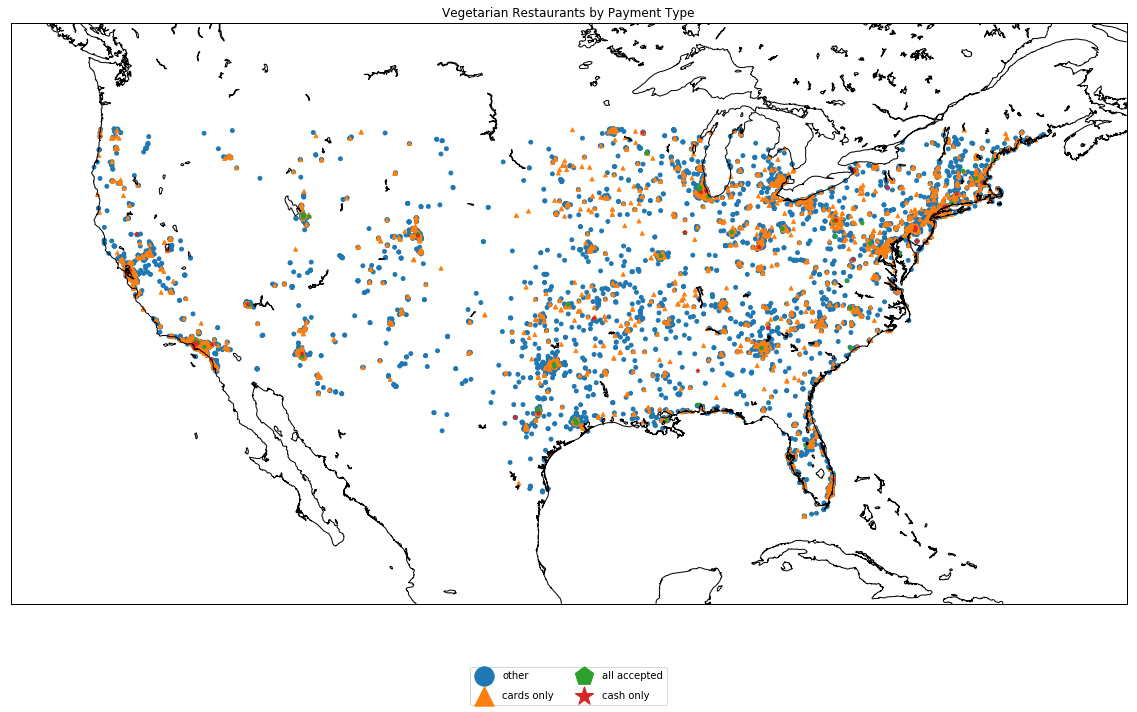

In [30]:
plottingDat = cleanedDat[(cleanedDat.long < -67) & (cleanedDat.long > -125) & 
                          (cleanedDat.lat > 24) & (cleanedDat.lat < 45) &
                         (cleanedDat.paymentType.notnull())]

# Plot based all restaurants
plt.figure(figsize=(20,20))
plot_map(plottingDat['long'], plottingDat['lat'], color = plottingDat.paymentType, min_marker_size= 15,
        title = 'Vegetarian Restaurants by Payment Type')

## Cuisine Type Stats

In this section I will examine the styles of food vegetarian restaurants are. I will also examine the number of pure vegetarian restuarants vs those that also serve meat.

In [31]:
# Add a column for other foods
tmp = np.where(cleanedDat.filter(regex='Food').apply(lambda x: np.where(x, 1, 0)).apply(np.sum, axis = 1) > 0, False, True)
foodDat = cleanedDat.assign(otherFood = tmp)

In [32]:
# Function to look at different stats based on food type
def calcStatByFoodType(dat, statVar, stat, 
                       label = None, title = None):
    if not callable(stat):
        raise TypeError('Stat object must be a function')
    
    # Loop through different food and create dictionary to create barplot
    foods = dat.filter(regex = 'Food').columns.tolist()
    foodDict = {}
    for food in foods:
        # Filter to positive data
        tmp = dat[dat[food]]
        
        if tmp.shape[0] == 0:
            foodDict[food] = 0
        else:
            # Need to handle situations where column may have all missing data
            val = stat(tmp[statVar])
            if pd.isnull(val):
                foodDict[food] = 0
            else:
                foodDict[food] = val
    
    # Plot data
    plt.barh(range(len(foodDict)), list(foodDict.values()), align='center')
    plt.yticks(range(len(foodDict)), list(foodDict.keys()))
    
    if not label is None:
        plt.xlabel(label)
    
    if not title is None:
        plt.title(title)
    
    

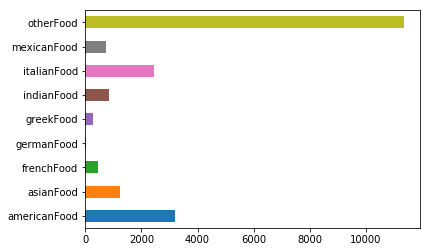

In [33]:
# Overall distribution of foods
foodDat.filter(regex = 'Food').apply(lambda x: np.where(x, 1, 0)).apply(np.sum).plot.barh()

####  Pop, Wealth, Price

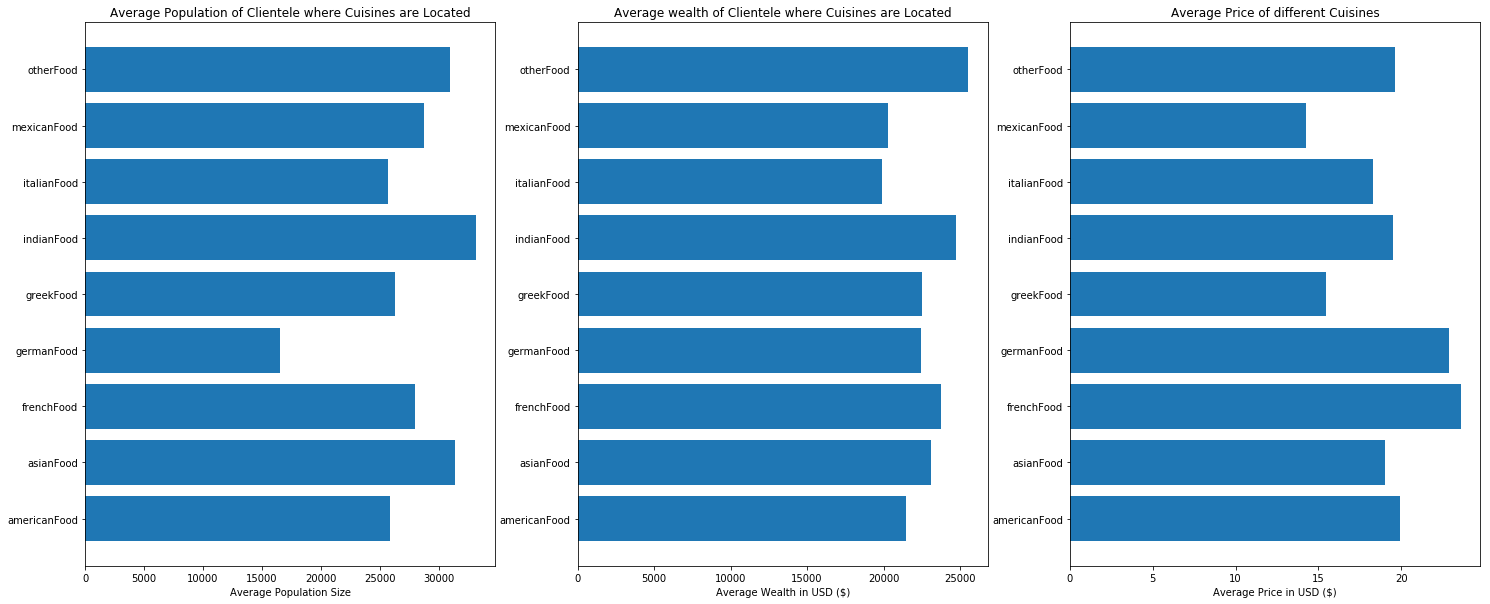

In [34]:
plt.figure(figsize=(25, 10))

# Fix infinity issues in wealthy and population
plt.subplot(1, 3, 1)
calcStatByFoodType(foodDat[foodDat.Population != np.inf], 'Population', lambda x: round(np.mean(x), 2), 
                   label = 'Average Population Size', 
                   title = 'Average Population of Clientele where Cuisines are Located')
plt.subplot(1, 3, 2)
calcStatByFoodType(foodDat[foodDat.Wealthy != np.inf], 'Wealthy', lambda x: round(np.mean(x), 2), 
                   label = 'Average Wealth in USD ($)', 
                   title = 'Average wealth of Clientele where Cuisines are Located')
plt.subplot(1, 3, 3)
calcStatByFoodType(foodDat, 'avgPrice', lambda x: round(np.mean(x), 2), 
                   label = 'Average Price in USD ($)', 
                   title = 'Average Price of different Cuisines')

####  Ratings

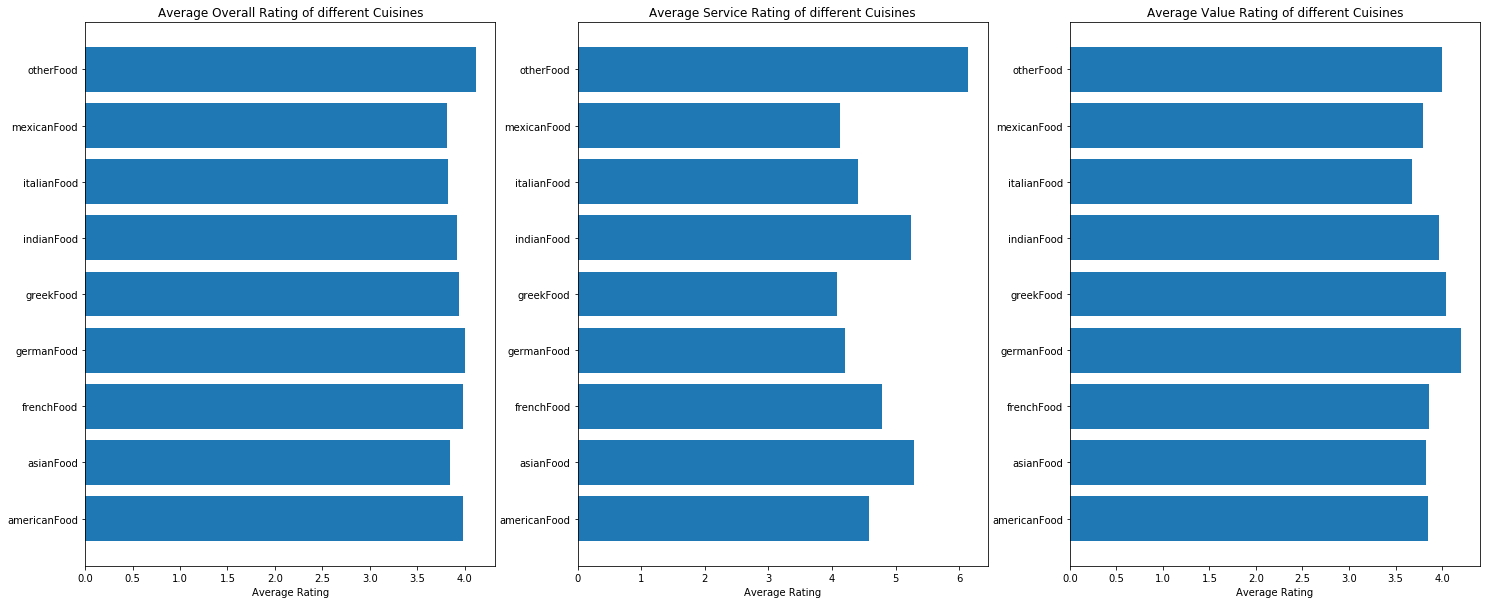

In [35]:
plt.figure(figsize=(25, 10))

# Fix infinity issues in wealthy and population
plt.subplot(1, 3, 1)
calcStatByFoodType(foodDat, 'overallRating', lambda x: round(np.mean(x), 2), 
                   label = 'Average Rating', 
                   title = 'Average Overall Rating of different Cuisines')
plt.subplot(1, 3, 2)
calcStatByFoodType(foodDat, 'serviceRating', lambda x: round(np.mean(x), 2), 
                   label = 'Average Rating', 
                   title = 'Average Service Rating of different Cuisines')
plt.subplot(1, 3, 3)
calcStatByFoodType(foodDat, 'valueRating', lambda x: round(np.mean(x), 2), 
                   label = 'Average Rating', 
                   title = 'Average Value Rating of different Cuisines')


## Dates

In this section I will look at when the resturants opened. Unfortunatley, there are only a small amount of restaurants with dates that opened so I will try to fill in the open date based on other information.

In [36]:
dateDat = cleanedDat.filter(regex = 'open').dropna()

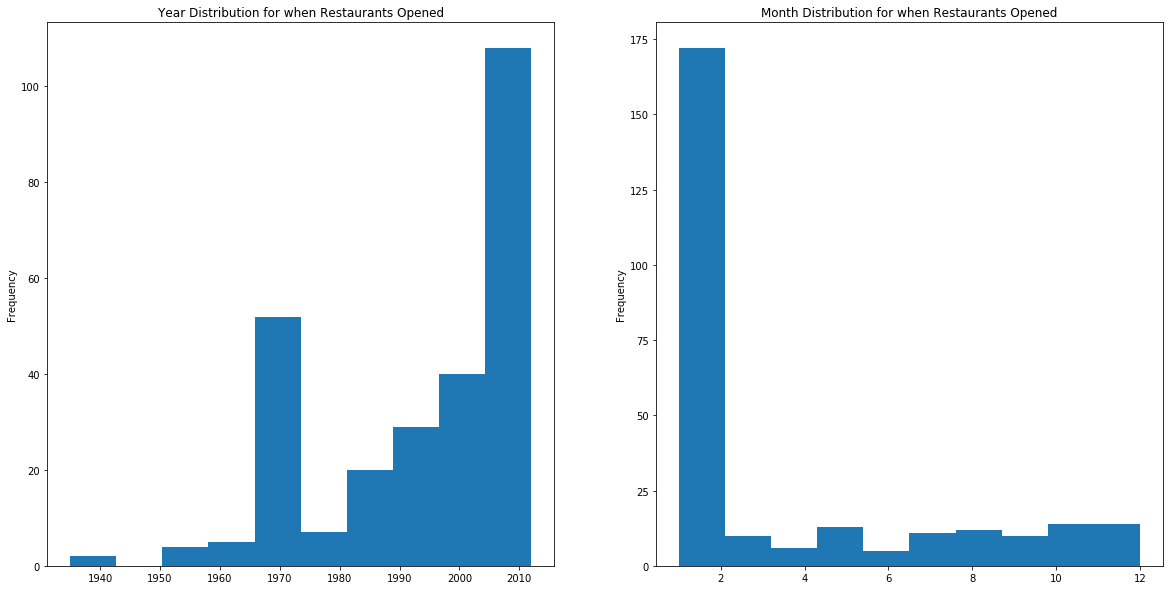

In [37]:
# Fix infinity issues in wealthy and population
fig, axes = plt.subplots(figsize=(20, 10), nrows = 1, ncols = 2)

resPlt1 = dateDat.openYear.plot.hist(ax = axes[0], title = 'Year Distribution for when Restaurants Opened')
resPlt2 = dateDat.openMonth.plot.hist(ax = axes[1], title = 'Month Distribution for when Restaurants Opened')
